In [1]:
%matplotlib inline
%run ../setup/nb_setup

# Collections of Orbits 3: Stellar streams

Author(s): Helmer Koppelman


## Introduction

In this notebook we will analyze the evolution of stellar systems like globular clusters and other satellites in Milky Way like galaxies. We will assume that the generated satellite *magically* becomes gravitationally unbound once it is launched on some initial orbit. 

For simplicty we will generate mock stellar systems from a normal distribution - for extra kudos you can use the self-consistent Plummer systems from Notebook 2! 


### Notebook Setup and Package Imports

In [2]:
# Essential - general
import numpy as np
import matplotlib.pyplot as plt

# Essential - astro
import astropy.units as u
import gala.integrate as gi
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

# Style
import matplotlib as mpl
import matplotlib.cm as cm

### Streams in a Milky Way potential  

First we will set-up the Milky Way potential. Modify the potential below if you want to redo the exercise in a different potential.

In [3]:
potential = gp.MilkyWayPotential(units=galactic)

# Optional: run the notebook with a spherical Milky Way.
# potential = gp.NFWPotential(m=1e12*u.Msun, r_s = 15*u.kpc, units=galactic)

Now we will generate a compact satellite galaxy by sampling random points from a normal distribution. Optionally, you could use the Plummer model that you created in the previous notebook. 

The code below samples $10^3$ particles – try to change it to $10^4$ if your laptop can handle the orbit calculations.

The satellite with suggested size of $\sigma_{\rm pos} = 0.1$ kpc and $\sigma_{\rm pos} = 2$ km/s resembles a (larg-ish) globular cluster. An optional exercise is to change the initial conditions to create a larger system that is more like a dwarf galaxy (e.g. 1 kpc and 20 km/s).

In [4]:
rng = np.random.default_rng(3)

N = 1_000
pos = rng.normal(loc=0, scale=0.1, size=(3, N)) * u.kpc
vel = rng.normal(loc=0, scale=2, size=(3, N)) * u.km / u.s

Just for reference, we will now insert a particle at the centre of the distribution, i.e. located at (x,v) = (0,0) [kpc, km/s]. At all times, this particle will represent the central orbit of the satellite and we can use it to inspect the orbits of the other particles relative to it.

In [5]:
pos[:, 0] *= 0
vel[:, 0] *= 0

Next, we will put the system on the orbit specified below and integrate the system in a Milky Way potential (i.e. the gala `gala.potential.MilkyWayPotential`). The `get_central_IC` function below contains four suggested orbits to try but feel free to launch the stream from other initial conditions.

Orbits 1, 2, and 3 are variations of regular orbits. Orbit 2 is a chaotic orbit – which might take a long time to calculate using `gala`. You might want to skip Orbit 2 and try the regular orbits.

In [6]:
def get_central_IC(orbit="1"):

    # Orbit 1 - Regular (loop)
    if orbit == "1":
        pos = [8.0, 0, 8.0] * u.kpc
        vel = [0, 150, 0] * u.km / u.s

    # Orbit 2 - (?)
    if orbit == "2":
        pos = [7.7, 0.0, -2.3] * u.kpc
        vel = [-66, 2, 98] * u.km / u.s

    # Orbit 3 - Regular (radial)
    if orbit == "3":
        pos = [8.0, 0, 8.0] * u.kpc
        vel = [0, 0, 0] * u.km / u.s

    # Orbit 4 - circular
    if orbit == "4":
        pos = [8.0, 0, 0] * u.kpc
        vc = potential.circular_velocity(pos)
        vel = vc * [0, 1, 0]
    return pos, vel


pos_c, vel_c = get_central_IC(orbit="1")

Adding the central orbits to the generated system:

In [7]:
vel += vel_c[:, np.newaxis]
pos += pos_c[:, np.newaxis]

w0 = gd.PhaseSpacePosition(pos=pos, vel=vel)

Finally, we are at the part where we can integrate the system. The code below integrates the satellite for 2 Gyr forward in time. 

If it takes long to calculate the orbits (>5 min, on my laptop it takes less than 1 min) try to decrease the number of particles in the satellite. And to stress: the chaotic orbit (Orbit 2) might take a bit longer than this - also the radial orbit (Orbit 3) might take a bit longer than Orbits 1 and 4.

In [8]:
Hamiltonian = gp.Hamiltonian(potential)

orbits = Hamiltonian.integrate_orbit(
    w0, t=np.linspace(0, 2, 500) * u.Gyr, Integrator=gi.DOPRI853Integrator
)

orbit_c = Hamiltonian.integrate_orbit(
    w0[0], t=np.linspace(0, 2, 5000) * u.Gyr, Integrator=gi.DOPRI853Integrator
)

`orbits` contains the orbits of all `N_star` particles
It's shape is `(times, particles)`, meaning that the 3rd time-step of the 5th particles is stored at `orbits[3,5]` and the full orbit of particle 5 can be obtained using `orbits[:,5]`.

Just for simplicity we've also calculated just the central orbit of the satellite at the same time-steps: `orbit_c`.

In [9]:
orbits.shape, orbit_c.shape

((500, 1000), (5000,))

### Exercise
- Plot the spatial evolution of the system in two planes (e.g. (x,y) and (x,z)) and at various times (e.g. 1, 2, ..., 5 Gyr)  
- Comment on the behaviour of the particles as time goes by. What do you see happens? Can you explain qualitatively the reason for the behaviour observed?

Optional: Try to inspect the evolution of the stream in different coordinate projections (x,y,z) – or perhaps even in spherical or cylindrical coordinates using `orbits.spherical`, `orbits.cylindrical`.

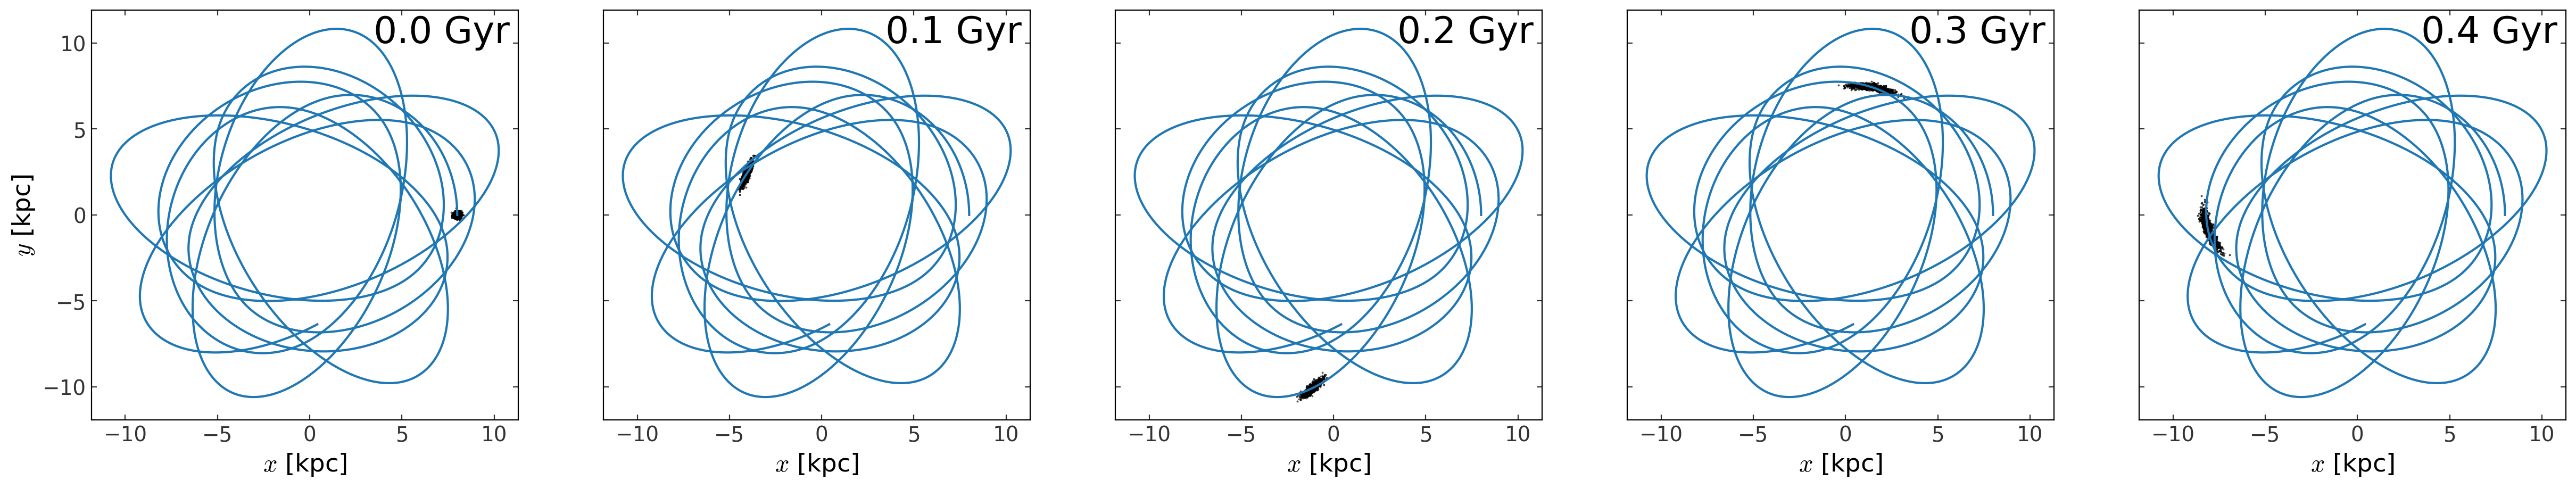

In [10]:
frames = np.arange(0, 5) * 25
frames[-1] -= 1

fig, axes = plt.subplots(ncols=5, figsize=(30, 5), sharex=True, sharey=True)

text_args = dict(x=0.98, y=0.99, va="top", ha="right", fontsize=25)
x, y, z = orbit_c.xyz

for (frame, ax) in zip(frames, axes):
    o, time = orbits[frame, :], orbits.t[frame]

    plt.text(s=time.to("Gyr").round(2), transform=ax.transAxes, **text_args)

    ax.scatter(o.x.to("kpc"), o.y.to("kpc"), s=0.1, c="k")
    ax.plot(x, y)

    ax.set_xlabel("$x$ [kpc]")
axes[0].set_ylabel("$y$ [kpc]")

plt.show()

### Evolution of disance to centre of stream

### Exercise
- Take the central particle and one random other particle and calculate the evolution of their separation $r(t) = |\vec{x_1} - \vec{x_2}|$. What do you find? How does this depend on the orbits?
- On average the distance between particles in the stream grows linear in time, but what causes the large fluctuations? Try comparing the figure below to the distance of the central particle to the centre of the Milky Way. For example, try to see if the fluctuations coincide with the turning-points in the orbit (i.e. apocentre and pericentre).
- (Optional) The example below shows a slight modulation - do you find this modulation also for the spherical potential? Or for the circular orbit?

In [11]:
# Distance between orbit 0 and orbit 1
dr = np.linalg.norm(orbits[:, 0].xyz - orbits[:, 1].xyz, axis=0)

Text(0.5, 0, 'time [Myr]')

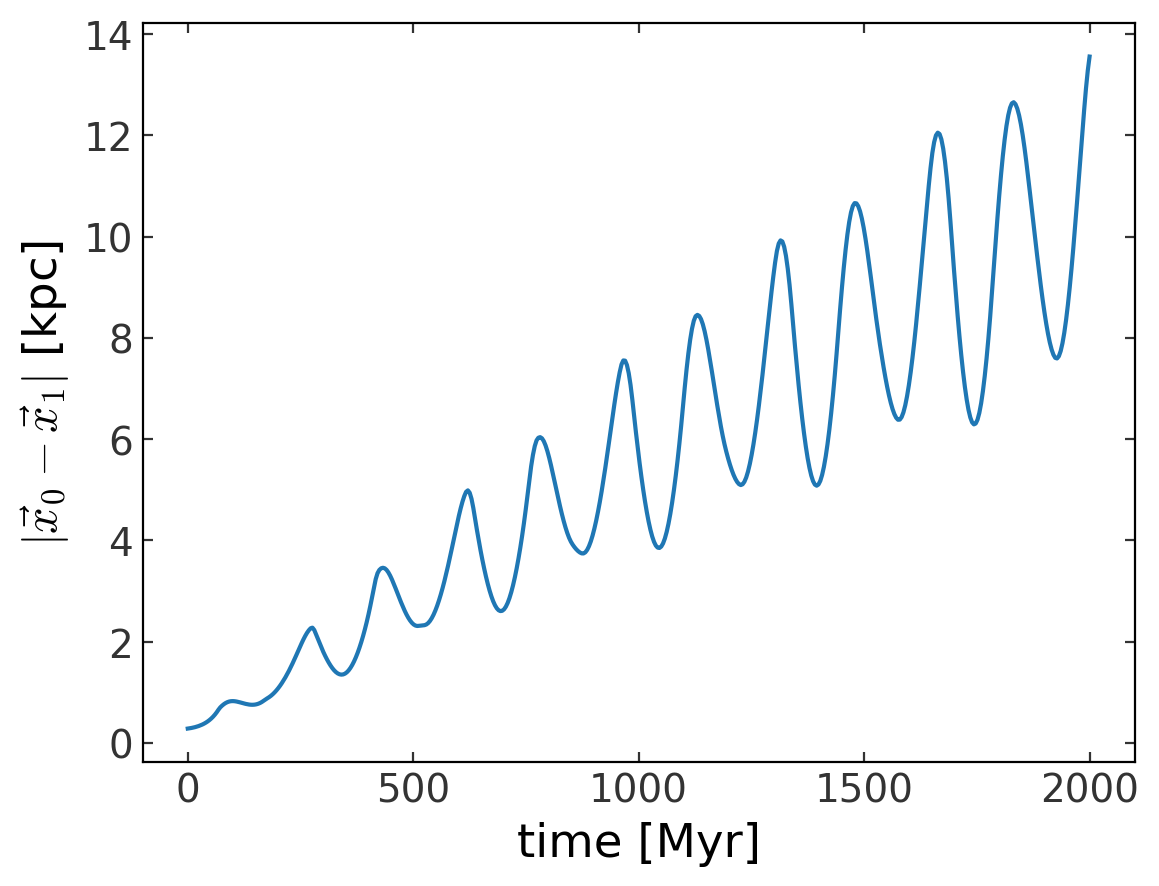

In [12]:
plt.plot(orbits.t, dr)
plt.ylabel(r"$|\vec{x}_0 - \vec{x}_1|$" + " [{}]".format(dr.unit))
plt.xlabel("time [{}]".format(orbits.t.unit))

### Optional exercises

- What are the differences in the behaviour between the orbits? 
- How would you explain the differing behaviours?
- Colour the particles by the orbital energy and discuss the results. What is the energy of the leading arm relative to the central particle? And what about the trailing arm?
- What happens if you change the size of the initial distribution?
- Overplot the central orbit on the spatial evolution and use it to explain what you see. Is the stream always aligned with this, why or why not?

Hint: gala can compute the orbital energy using `orbit.energy()`.  

---
### For fun
- Try to create a 3D rendering/animation of the stream (see the additional notebook)

---

### Advanced optional exercises
(Advanced: probably this will take too much time!)  


Streams and actions and angles
- Use gala to calculate actions and angles and plot the distribution of these for separate times (much like you have analyzed the evolution of the stream in (x,y,z).


In a sphere of radius 2 kpc centred on the central particle, inspect and discuss: 
- the number density of particles inside this volume as a function of time
- the total velocity dispersion of the same particles as a function of time $(\sigma_v = \sqrt{\sigma_{vx}^2+\sigma_{vy}^2+\sigma_{vz}^2})$    

NB: for the last exercise more particles is better if your laptop can handle it.